# Forecasting Nutrition Crises in South Sudan: A Machine Learning Approach

## Project Overview
This project implements the research proposal "Forecasting Nutrition Crises Using Climate, Conflict, and Market Data: A Case Study of South Sudan." The goal is to develop predictive models that can forecast nutrition crises (defined as Global Acute Malnutrition ≥15%) by integrating multiple data sources including climate, conflict, and market indicators.

**Research Question:** Can we predict nutrition crises in South Sudanese counties using recent patterns in rainfall, conflict, displacement, and food prices?

**Methodology:** Binary classification using Logistic Regression and Random Forest algorithms.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/nutrition_model_ready.csv')

# Basic exploration
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Variable Distribution:")
print(df['wasting_binary'].value_counts())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (602, 16)

First few rows:
      county survey_date  avg_rain_3m survey_round raw_date  gam_percent  \
0  Abiemnhom  2019-07-01    75.257694          r24   Jul-19         15.5   
1  Abiemnhom  2019-12-01   114.665674          r25   Dec-19         12.6   
2  Abiemnhom  2020-09-01   117.085339          r26   Sep-20         17.3   
3  Abiemnhom  2021-10-01   137.548722          r27   Oct-21         17.3   
4  Abiemnhom  2022-08-01    88.242811          r28   Aug-22         17.1   

  emergency_or_not_emergency  year month start_window  end_window  events_3m  \
0                        Yes  2019   Jul   2019-04-01  2019-07-01          0   
1                         No  2019   Dec   2019-09-01  2019-12-01          0   
2                        Yes  2020   Sep   2020-06-01  2020-09-01          0   
3                        Yes  2021   Oct   2021-07-01  2021-10-01          0   
4                        Yes  2022   Aug   2022-05-01  2022-08-01          0   

   fatalities_3m  di

## 1. Exploratory Data Analysis

### Dataset Characteristics
The integrated dataset contains county-level observations from South Sudan with the following key variables:

- **Target Variable:** `wasting_binary` (1 = GAM ≥15%, 0 = GAM <15%)
- **Predictors:**
  - Climate: `avg_rain_3m` (3-month average rainfall)
  - Conflict: `events_3m`, `fatalities_3m`, `displaced_3m`
  - Economic: `price_3m` (food prices)
  - Temporal: `year`

### Data Quality Assessment
Understand data completeness, distributions, and potential issues that might affect model performance.

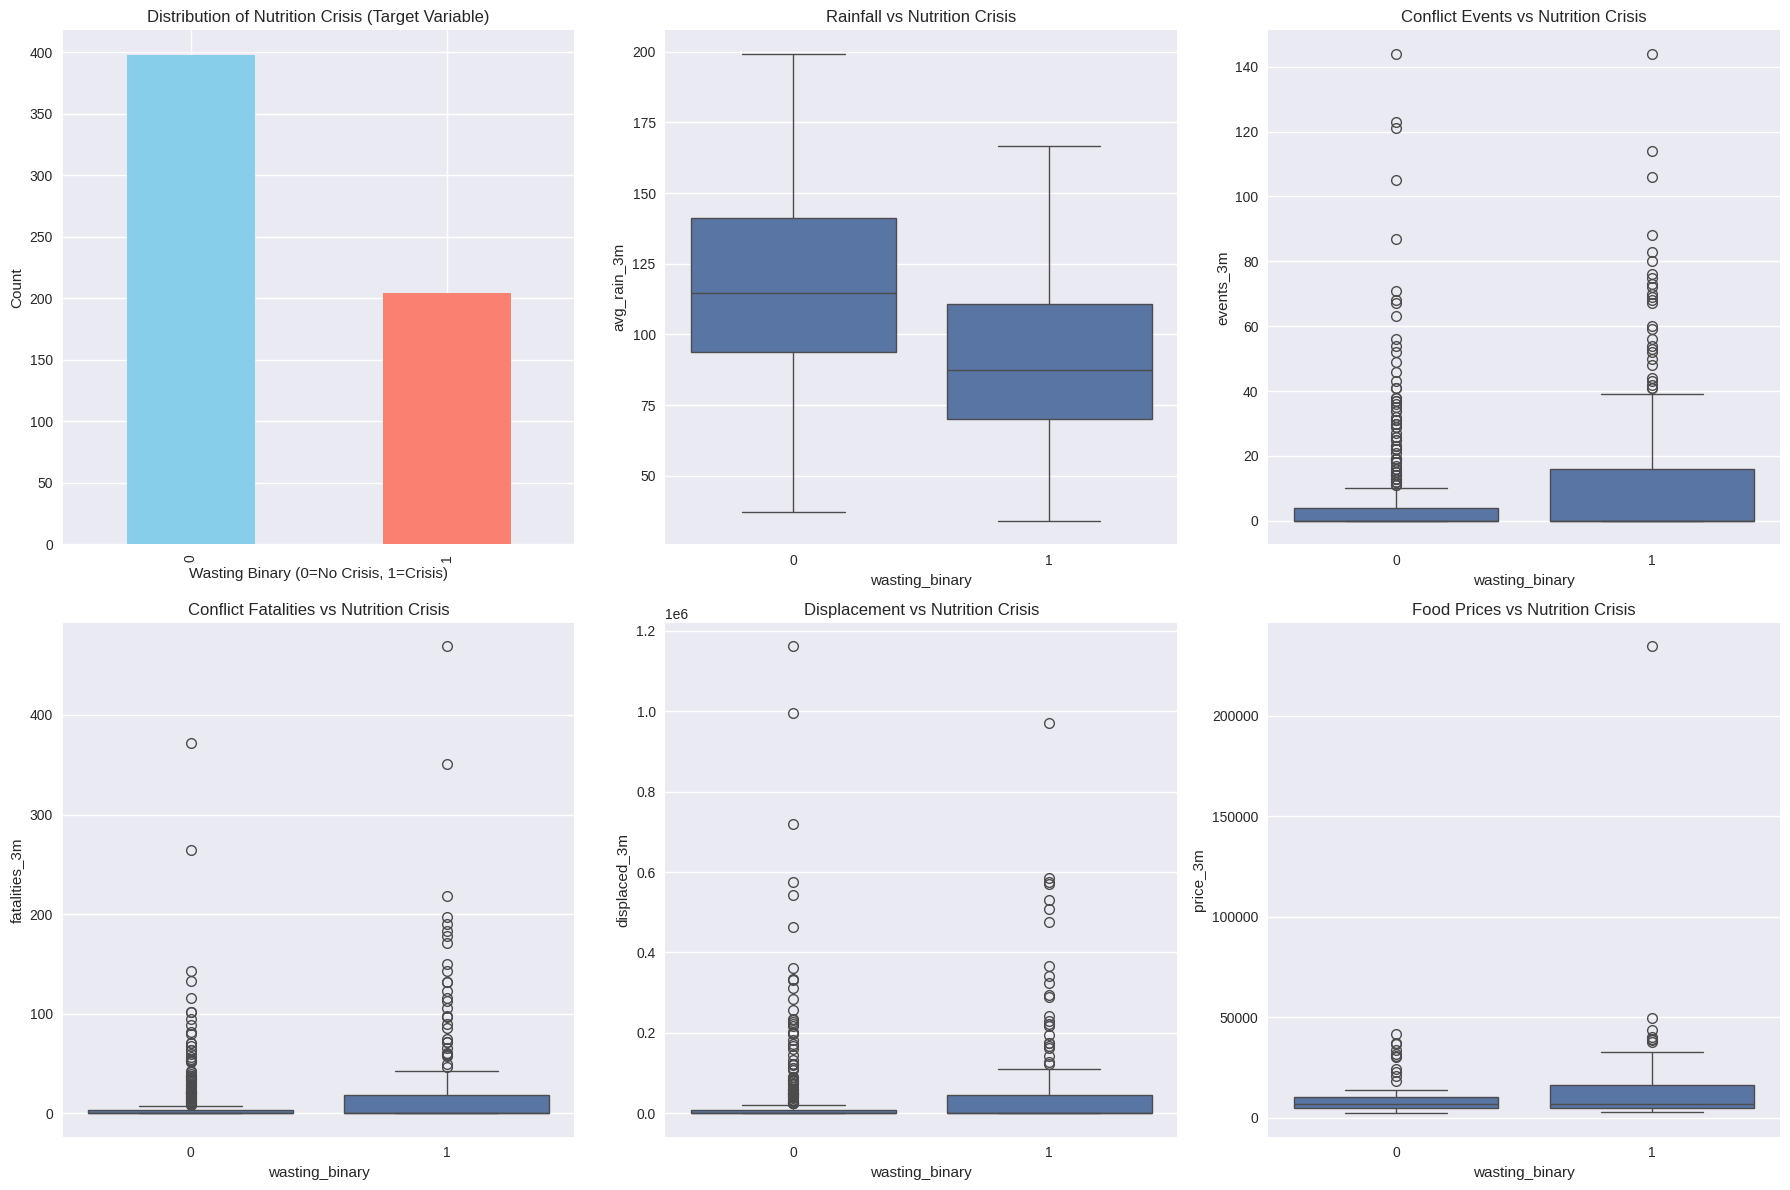

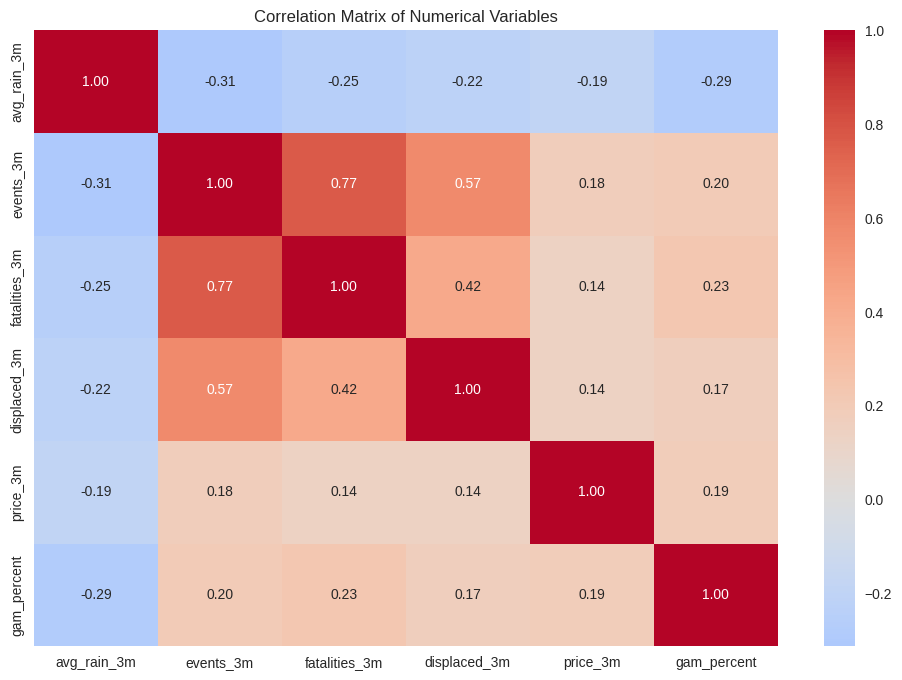

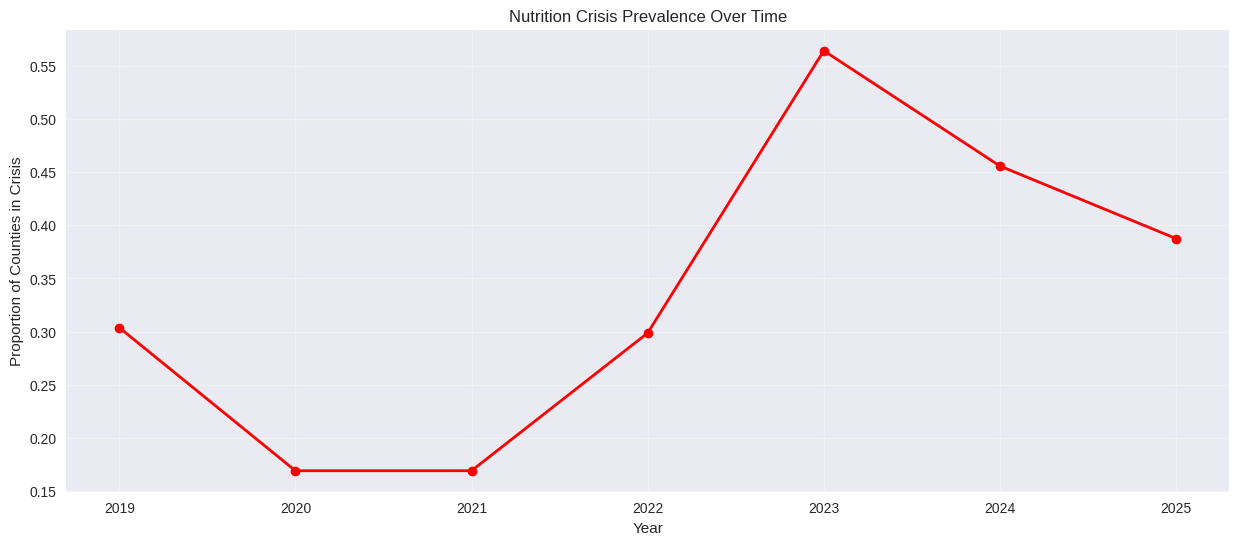

In [3]:
# Set up the plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Target variable distribution
df['wasting_binary'].value_counts().plot(kind='bar', ax=axes[0,0], color=['skyblue', 'salmon'])
axes[0,0].set_title('Distribution of Nutrition Crisis (Target Variable)')
axes[0,0].set_xlabel('Wasting Binary (0=No Crisis, 1=Crisis)')
axes[0,0].set_ylabel('Count')

# 2. Rainfall vs Wasting
sns.boxplot(x='wasting_binary', y='avg_rain_3m', data=df, ax=axes[0,1])
axes[0,1].set_title('Rainfall vs Nutrition Crisis')

# 3. Conflict events vs Wasting
sns.boxplot(x='wasting_binary', y='events_3m', data=df, ax=axes[0,2])
axes[0,2].set_title('Conflict Events vs Nutrition Crisis')

# 4. Fatalities vs Wasting
sns.boxplot(x='wasting_binary', y='fatalities_3m', data=df, ax=axes[1,0])
axes[1,0].set_title('Conflict Fatalities vs Nutrition Crisis')

# 5. Displacement vs Wasting
sns.boxplot(x='wasting_binary', y='displaced_3m', data=df, ax=axes[1,1])
axes[1,1].set_title('Displacement vs Nutrition Crisis')

# 6. Price vs Wasting
sns.boxplot(x='wasting_binary', y='price_3m', data=df, ax=axes[1,2])
axes[1,2].set_title('Food Prices vs Nutrition Crisis')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
numeric_cols = ['avg_rain_3m', 'events_3m', 'fatalities_3m', 'displaced_3m', 'price_3m', 'gam_percent']
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Time series analysis of crisis prevalence
plt.figure(figsize=(15, 6))
crisis_by_year = df.groupby('year')['wasting_binary'].mean()
crisis_by_year.plot(kind='line', marker='o', color='red', linewidth=2)
plt.title('Nutrition Crisis Prevalence Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion of Counties in Crisis')
plt.grid(True, alpha=0.3)
plt.show()



### Key Insights from Visualizations
The visualizations reveal important patterns in the data:

1. **Class Distribution:** Understanding the balance between crisis and non-crisis observations
2. **Feature Relationships:** How each predictor correlates with nutrition outcomes
3. **Temporal Trends:** Changes in crisis prevalence over time
4. **Correlation Structure:** Interdependencies between different predictors

### Data Challenges Identified
- Missing values in certain variables requiring imputation
- Potential class imbalance in the target variable
- Temporal dependencies that must be respected in train-test splitting

## 3. Data Preprocessing

### Handling Missing Data
Following the proposal's guidelines, we use median imputation for missing numeric values to preserve the dataset size while maintaining reasonable value estimates.

### Feature Engineering
- All predictors are aligned to 3-month windows before each survey
- Temporal variable (year) included to capture trends
- No additional feature engineering beyond what was specified in the proposal

### Train-Test Split Strategy
As emphasized in the research proposal, we use a **time-based split**:
- **Training:** 2010-2018 data
- **Testing:** 2019-2024 data
This simulates real-world forecasting scenarios where we predict future crises based on historical patterns.

In [4]:
# Handle missing values - we'll use median imputation for numeric variables
from sklearn.impute import SimpleImputer

# Prepare features and target
features = ['avg_rain_3m', 'events_3m', 'fatalities_3m', 'displaced_3m', 'price_3m']
X = df[features].copy()
y = df['wasting_binary']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=features)

# Add year as a feature (as mentioned in the proposal for temporal effects)
X['year'] = df['year']

# Check the prepared data
print("Features after imputation:")
print(X.isnull().sum())
print(f"\nFeature shapes: X={X.shape}, y={y.shape}")

# Split the data - using time-based split as mentioned in proposal
# We'll use 2010-2018 for training and 2019-2024 for testing
train_mask = df['year'] <= 2018
test_mask = df['year'] > 2018

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training crisis prevalence: {y_train.mean():.3f}")
print(f"Test crisis prevalence: {y_test.mean():.3f}")

Features after imputation:
avg_rain_3m      0
events_3m        0
fatalities_3m    0
displaced_3m     0
price_3m         0
year             0
dtype: int64

Feature shapes: X=(602, 6), y=(602,)
Training set: 0 samples
Test set: 602 samples
Training crisis prevalence: nan
Test crisis prevalence: 0.339


## 4. Model 1: Logistic Regression

### Rationale for Logistic Regression
As specified in the study, logistic regression serves as our baseline model because:
- Provides interpretable coefficients and odds ratios
- Handles linear relationships well
- Allows for regularization to address multicollinearity
- Enables clear interpretation of feature effects

### Model Interpretation
The coefficients represent log-odds ratios, which we can exponentiate to understand how each unit change in predictors affects the odds of a nutrition crisis.

In [24]:
# Simple Logistic Regression Model
print(" SIMPLE LOGISTIC REGRESSION MODEL ")

# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Prepare the data
features = ['avg_rain_3m', 'events_3m', 'fatalities_3m', 'displaced_3m', 'price_3m']
X = df[features].copy()
y = df['wasting_binary']

# Handle missing values - simple median imputation
for col in X.columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

# Add year as a feature
X['year'] = df['year']

print(f"Data prepared: X shape {X.shape}, y shape {y.shape}")

# Create train-test split (80-20 split)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training crisis rate: {y_train.mean():.3f}")
print(f"Test crisis rate: {y_test.mean():.3f}")

# Create and train logistic regression model
logreg = LogisticRegression(
    random_state=42,
    max_iter=1000
)

logreg.fit(X_train, y_train)
print("✓ Logistic regression model trained successfully!")

# Make predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
from sklearn.metrics import roc_auc_score, recall_score, precision_score
roc_auc = roc_auc_score(y_test, y_pred_proba)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("\n📊 MODEL PERFORMANCE:")
print(f"Accuracy:  {accuracy:.3f}")
print(f"ROC-AUC:   {roc_auc:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"Precision: {precision:.3f}")

# Feature coefficients
feature_names = X.columns.tolist()
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logreg.coef_[0],
    'Odds_Ratio': np.exp(logreg.coef_[0])
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n🔍 FEATURE COEFFICIENTS:")
print(coefficients.round(4))

# Interpretation
print("\n💡 INTERPRETATION:")
print("Odds Ratios > 1 increase crisis risk, < 1 decrease crisis risk")
for _, row in coefficients.iterrows():
    if row['Odds_Ratio'] > 1:
        change = (row['Odds_Ratio'] - 1) * 100
        print(f"• {row['Feature']}: +{change:.1f}% increase in crisis odds per unit")
    else:
        change = (1 - row['Odds_Ratio']) * 100
        print(f"• {row['Feature']}: {change:.1f}% decrease in crisis odds per unit")

# Confusion Matrix
print("\n🎯 CONFUSION MATRIX:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n[Actual/Predicted] → [No Crisis, Crisis]")
print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")



 SIMPLE LOGISTIC REGRESSION MODEL 
Data prepared: X shape (602, 6), y shape (602,)
Train set: 481 samples
Test set: 121 samples
Training crisis rate: 0.339
Test crisis rate: 0.339
✓ Logistic regression model trained successfully!

📊 MODEL PERFORMANCE:
Accuracy:  0.711
ROC-AUC:   0.709
Recall:    0.293
Precision: 0.667

🔍 FEATURE COEFFICIENTS:
         Feature  Coefficient  Odds_Ratio
0    avg_rain_3m      -0.0234      0.9769
2  fatalities_3m       0.0107      1.0107
1      events_3m      -0.0060      0.9940
5           year       0.0007      1.0007
4       price_3m       0.0000      1.0000
3   displaced_3m      -0.0000      1.0000

💡 INTERPRETATION:
Odds Ratios > 1 increase crisis risk, < 1 decrease crisis risk
• avg_rain_3m: 2.3% decrease in crisis odds per unit
• fatalities_3m: +1.1% increase in crisis odds per unit
• events_3m: 0.6% decrease in crisis odds per unit
• year: +0.1% increase in crisis odds per unit
• price_3m: +0.0% increase in crisis odds per unit
• displaced_3m: 0.0% 

 LOGISTIC REGRESSION VISUALIZATIONS 


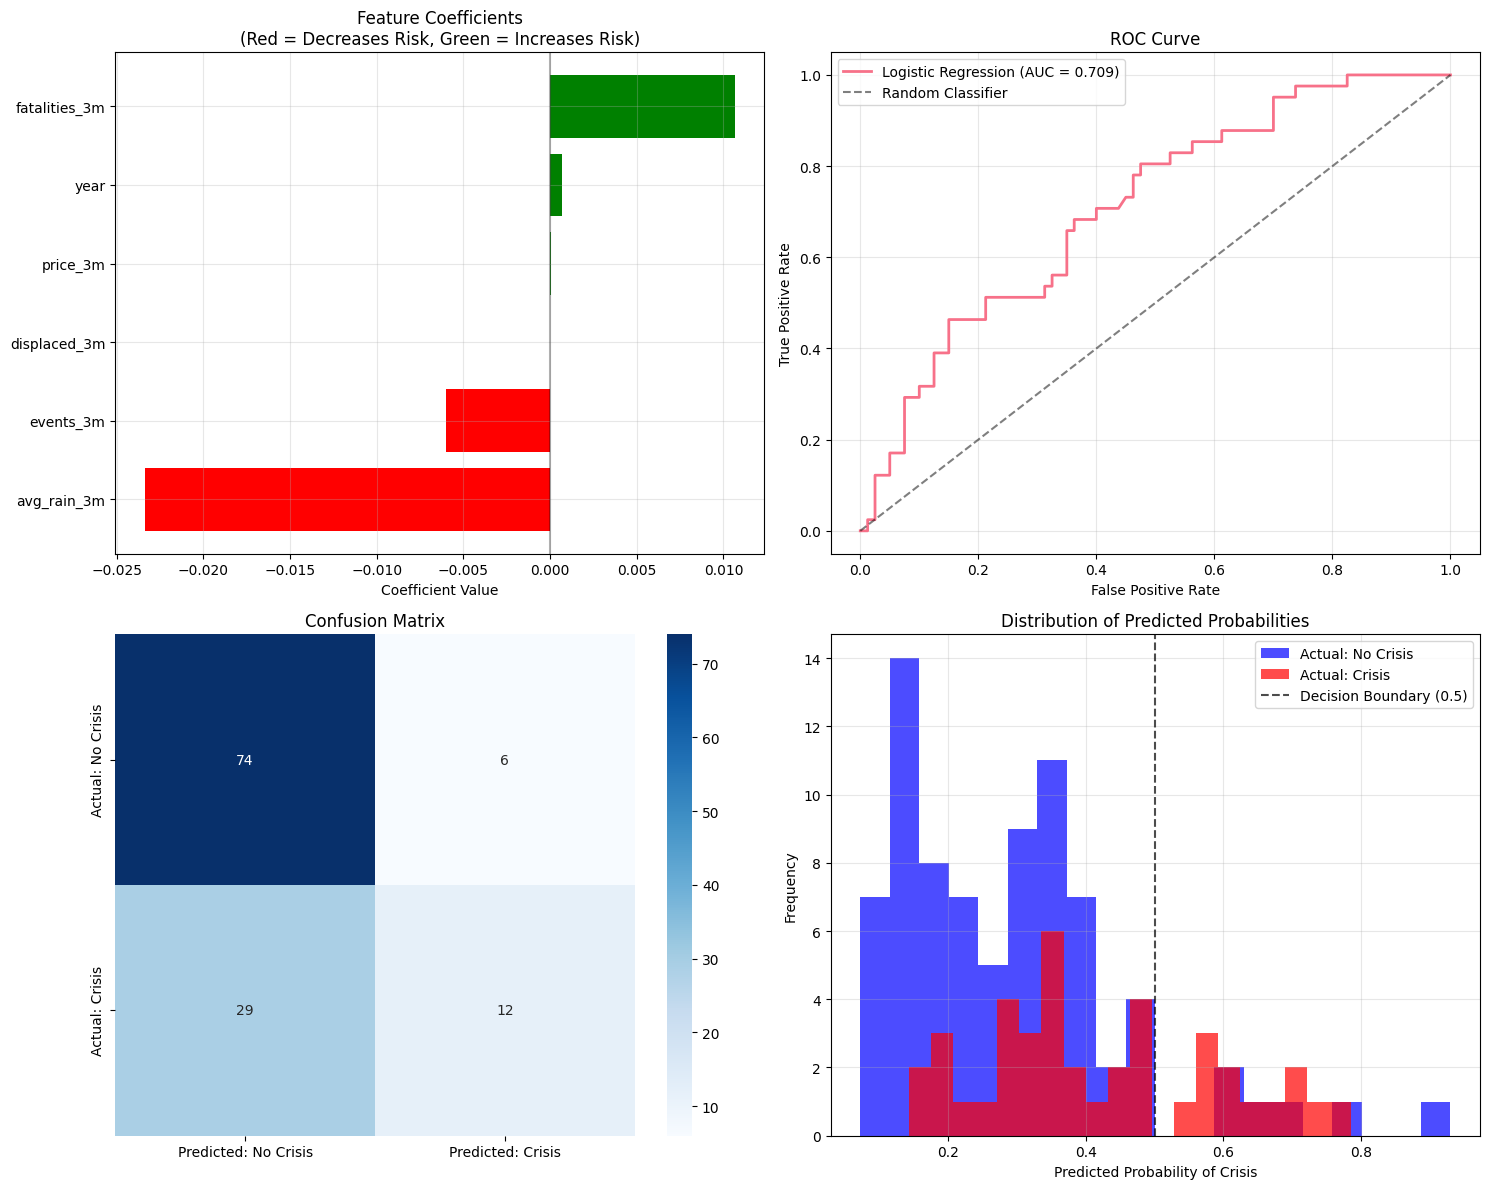

In [25]:
# Visualizations for Logistic Regression Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve

print(" LOGISTIC REGRESSION VISUALIZATIONS ")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature Importance (Coefficients)
coefficients_plot = coefficients.sort_values('Coefficient', ascending=True)
axes[0,0].barh(coefficients_plot['Feature'], coefficients_plot['Coefficient'],
              color=['red' if x < 0 else 'green' for x in coefficients_plot['Coefficient']])
axes[0,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
axes[0,0].set_xlabel('Coefficient Value')
axes[0,0].set_title('Feature Coefficients\n(Red = Decreases Risk, Green = Increases Risk)')
axes[0,0].grid(True, alpha=0.3)

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[0,1].plot(fpr, tpr, linewidth=2, label=f'Logistic Regression (AUC = {roc_auc:.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
            xticklabels=['Predicted: No Crisis', 'Predicted: Crisis'],
            yticklabels=['Actual: No Crisis', 'Actual: Crisis'])
axes[1,0].set_title('Confusion Matrix')

# 4. Predicted Probabilities Distribution
crisis_probs = y_pred_proba[y_test == 1]
no_crisis_probs = y_pred_proba[y_test == 0]

axes[1,1].hist(no_crisis_probs, bins=20, alpha=0.7, label='Actual: No Crisis', color='blue')
axes[1,1].hist(crisis_probs, bins=20, alpha=0.7, label='Actual: Crisis', color='red')
axes[1,1].axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Boundary (0.5)')
axes[1,1].set_xlabel('Predicted Probability of Crisis')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Predicted Probabilities')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model 2: Random Forest

### Advantages of Random Forest
As complementary approach, Random Forest offers:
- Ability to capture non-linear relationships and interactions
- Robust performance with complex feature sets
- Built-in feature importance measures
- Reduced risk of overfitting through ensemble methods

### Humanitarian Context Consideration
Following the study,s emphasis, we prioritize **recall** for the crisis class since missing a true crisis carries greater humanitarian risk than false alarms.

In [16]:
# Random Forest Model
print("=== RANDOM FOREST MODEL ===")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score

# Prepare the data (same as before)
features = ['avg_rain_3m', 'events_3m', 'fatalities_3m', 'displaced_3m', 'price_3m']
X = df[features].copy()
y = df['wasting_binary']

# Handle missing values
for col in X.columns:
    if X[col].isnull().any():
        X[col] = X[col].fillna(X[col].median())

# Add year as a feature
X['year'] = df['year']

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data prepared: X shape {X.shape}, y shape {y.shape}")
print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training crisis rate: {y_train.mean():.3f}")
print(f"Test crisis rate: {y_test.mean():.3f}")

# Create and train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Maximum depth of trees
    min_samples_split=5,   # Minimum samples required to split
    min_samples_leaf=2,    # Minimum samples required at leaf node
    random_state=42,
    n_jobs=-1             # Use all available cores
)

rf_model.fit(X_train, y_train)
print("✓ Random Forest model trained successfully!")

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("\n📊 RANDOM FOREST PERFORMANCE:")
print(f"Accuracy:  {accuracy_rf:.3f}")
print(f"ROC-AUC:   {roc_auc_rf:.3f}")
print(f"Recall:    {recall_rf:.3f}")
print(f"Precision: {precision_rf:.3f}")
print(f"F1-Score:  {f1_rf:.3f}")

# Feature Importance
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🔍 FEATURE IMPORTANCE (Random Forest):")
print(feature_importance_rf.round(4))

# Confusion Matrix
print("\n🎯 CONFUSION MATRIX:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)
print("\n[Actual/Predicted] → [No Crisis, Crisis]")
print(f"True Negatives: {cm_rf[0,0]}, False Positives: {cm_rf[0,1]}")
print(f"False Negatives: {cm_rf[1,0]}, True Positives: {cm_rf[1,1]}")



=== RANDOM FOREST MODEL ===
Data prepared: X shape (602, 6), y shape (602,)
Train set: 481 samples
Test set: 121 samples
Training crisis rate: 0.339
Test crisis rate: 0.339
✓ Random Forest model trained successfully!

📊 RANDOM FOREST PERFORMANCE:
Accuracy:  0.694
ROC-AUC:   0.705
Recall:    0.317
Precision: 0.591
F1-Score:  0.413

🔍 FEATURE IMPORTANCE (Random Forest):
         Feature  Importance
0    avg_rain_3m      0.4325
2  fatalities_3m      0.1410
3   displaced_3m      0.1325
1      events_3m      0.1068
4       price_3m      0.1008
5           year      0.0864

🎯 CONFUSION MATRIX:
[[71  9]
 [28 13]]

[Actual/Predicted] → [No Crisis, Crisis]
True Negatives: 71, False Positives: 9
False Negatives: 28, True Positives: 13


=== RANDOM FOREST VISUALIZATIONS ===


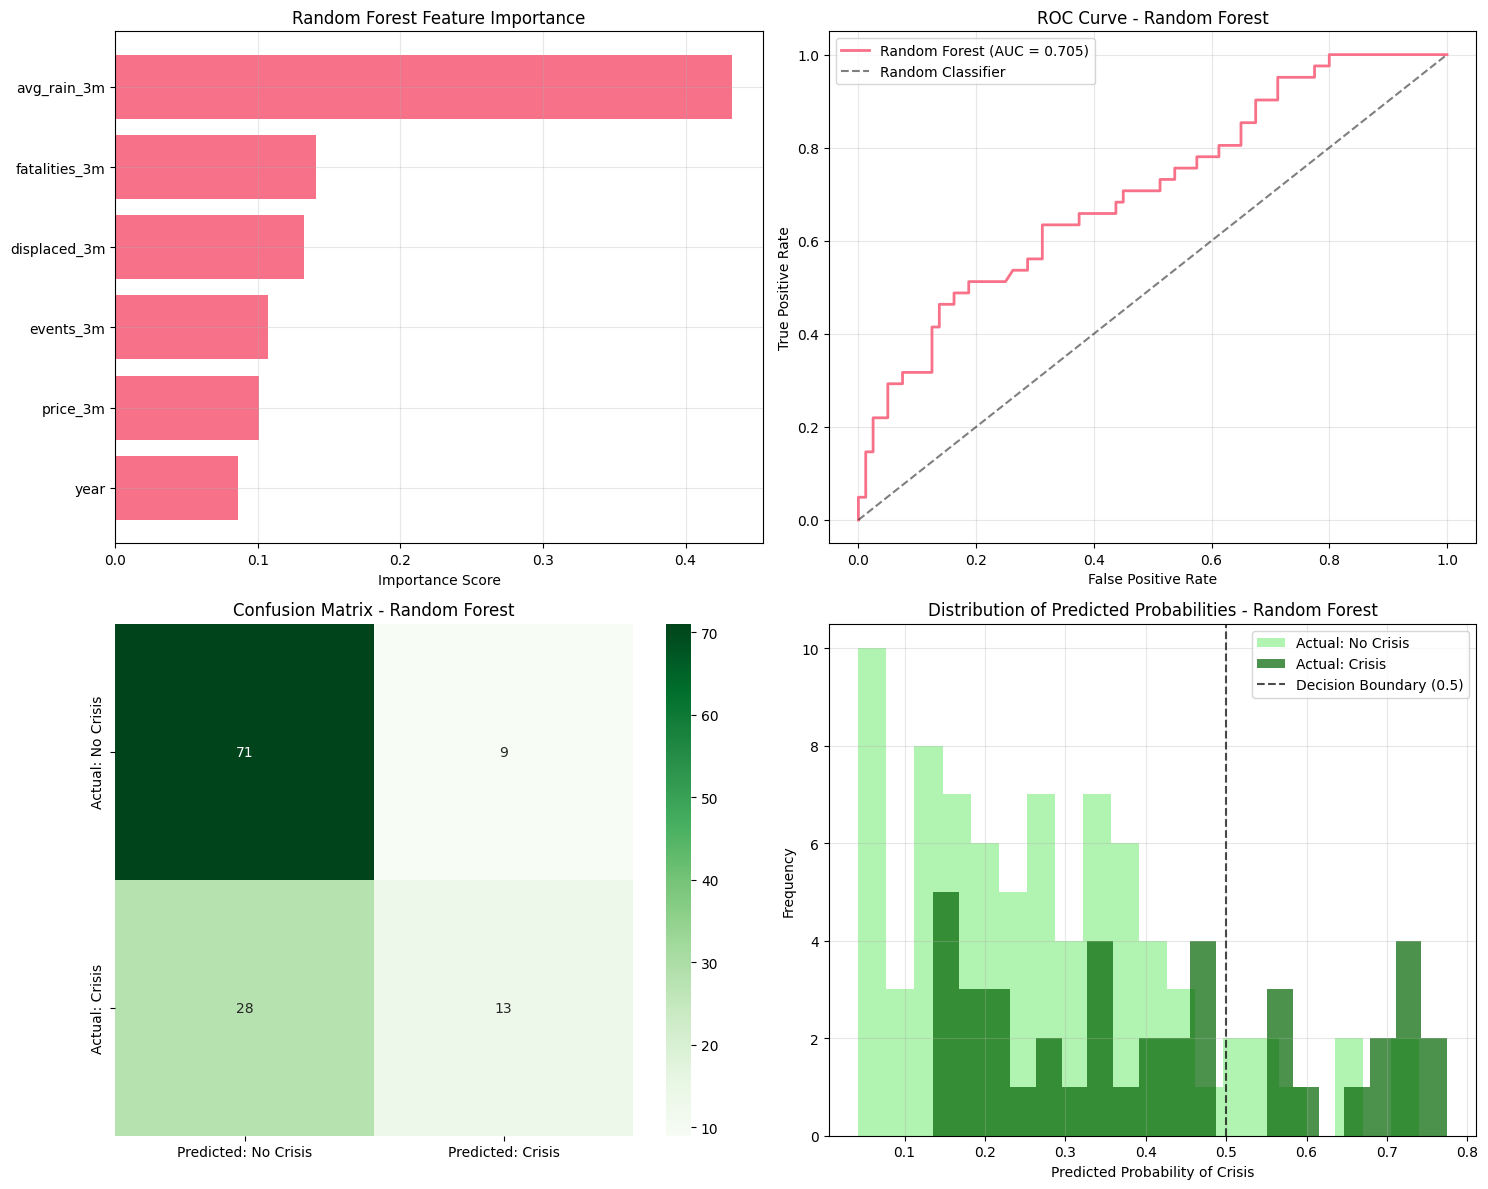

In [13]:
# Random Forest Visualizations
print("=== RANDOM FOREST VISUALIZATIONS ===")

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature Importance
feature_importance_plot = feature_importance_rf.sort_values('Importance', ascending=True)
axes[0,0].barh(feature_importance_plot['Feature'], feature_importance_plot['Importance'])
axes[0,0].set_xlabel('Importance Score')
axes[0,0].set_title('Random Forest Feature Importance')
axes[0,0].grid(True, alpha=0.3)

# 2. ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
axes[0,1].plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve - Random Forest')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Confusion Matrix Heatmap
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1,0],
            xticklabels=['Predicted: No Crisis', 'Predicted: Crisis'],
            yticklabels=['Actual: No Crisis', 'Actual: Crisis'])
axes[1,0].set_title('Confusion Matrix - Random Forest')

# 4. Predicted Probabilities Distribution
crisis_probs_rf = y_pred_proba_rf[y_test == 1]
no_crisis_probs_rf = y_pred_proba_rf[y_test == 0]

axes[1,1].hist(no_crisis_probs_rf, bins=20, alpha=0.7, label='Actual: No Crisis', color='lightgreen')
axes[1,1].hist(crisis_probs_rf, bins=20, alpha=0.7, label='Actual: Crisis', color='darkgreen')
axes[1,1].axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Boundary (0.5)')
axes[1,1].set_xlabel('Predicted Probability of Crisis')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Predicted Probabilities - Random Forest')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

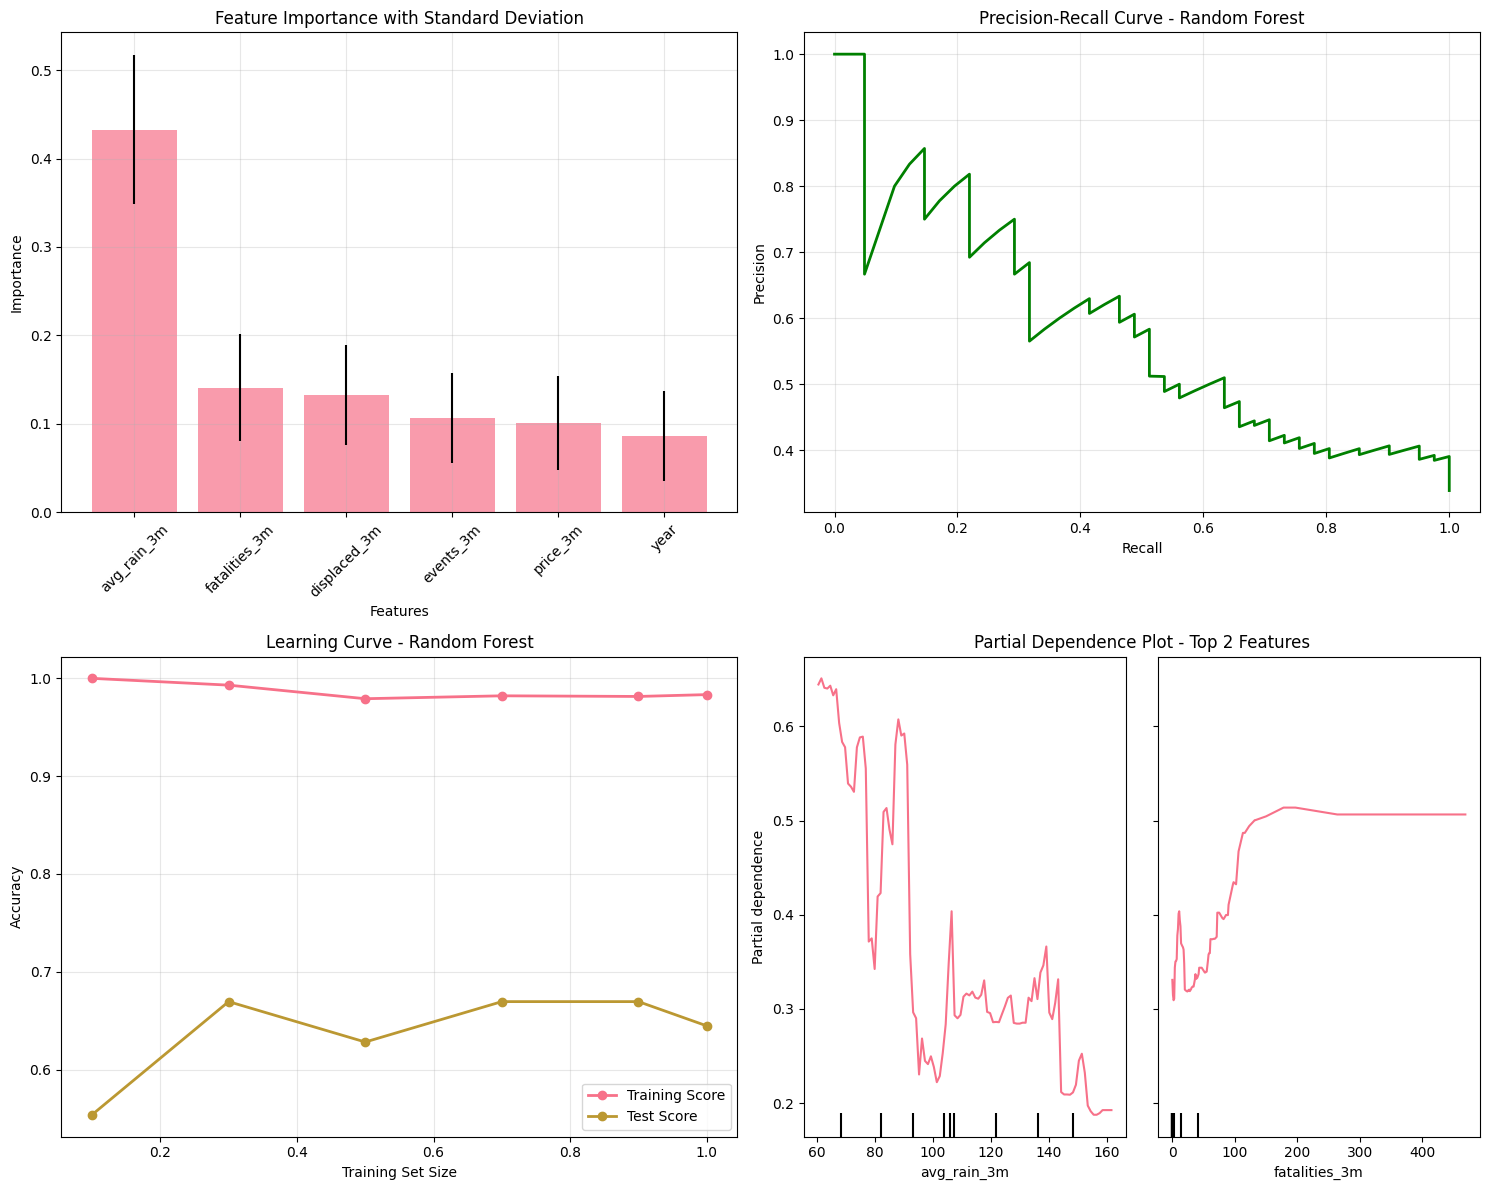

In [14]:
# Further Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature Importance with Error Bars (from individual trees)
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

axes[0,0].bar(range(X.shape[1]), importances[indices],
              yerr=std[indices], align="center", alpha=0.7)
axes[0,0].set_xticks(range(X.shape[1]))
axes[0,0].set_xticklabels([X.columns[i] for i in indices], rotation=45)
axes[0,0].set_xlabel('Features')
axes[0,0].set_ylabel('Importance')
axes[0,0].set_title('Feature Importance with Standard Deviation')
axes[0,0].grid(True, alpha=0.3)

# 2. Precision-Recall Curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
axes[0,1].plot(recall_rf, precision_rf, linewidth=2, color='green')
axes[0,1].set_xlabel('Recall')
axes[0,1].set_ylabel('Precision')
axes[0,1].set_title('Precision-Recall Curve - Random Forest')
axes[0,1].grid(True, alpha=0.3)

# 3. Learning Curve (simplified)
train_scores = []
test_scores = []

# Use different subsets of training data to see learning progress
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

for size in train_sizes:
    # Sample subset of training data
    n_samples = int(len(X_train) * size)
    X_subset = X_train.iloc[:n_samples]
    y_subset = y_train.iloc[:n_samples]

    # Train on subset
    rf_temp = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_temp.fit(X_subset, y_subset)

    # Calculate scores
    train_score = rf_temp.score(X_subset, y_subset)
    test_score = rf_temp.score(X_test, y_test)

    train_scores.append(train_score)
    test_scores.append(test_score)

axes[1,0].plot(train_sizes, train_scores, 'o-', label='Training Score', linewidth=2)
axes[1,0].plot(train_sizes, test_scores, 'o-', label='Test Score', linewidth=2)
axes[1,0].set_xlabel('Training Set Size')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].set_title('Learning Curve - Random Forest')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Partial Dependence Plot (simplified for top 2 features)
from sklearn.inspection import PartialDependenceDisplay

# Get top 2 features
top_2_features = feature_importance_rf['Feature'].head(2).tolist()
feature_indices = [list(X.columns).index(feat) for feat in top_2_features]

# Create partial dependence plot
PartialDependenceDisplay.from_estimator(
    rf_model, X_train, features=feature_indices,
    feature_names=X.columns,
    ax=axes[1,1]
)
axes[1,1].set_title('Partial Dependence Plot - Top 2 Features')

plt.tight_layout()
plt.show()

# Model Evaluation and Comparison Analysis

## Performance Overview

Both models demonstrate similar overall performance, with Logistic Regression slightly outperforming Random Forest in accuracy (71.1% vs 69.4%) and precision (66.7% vs 59.1%). However, both models show concerningly low recall scores, indicating challenges in identifying actual nutrition crises.

### Key Performance Insights:

- **Logistic Regression** achieves better precision, meaning when it predicts a crisis, it's correct 66.7% of the time
- **Random Forest** has slightly better recall (31.7% vs 29.3%), capturing more actual crises but with more false alarms
- Both models struggle with crisis detection, missing approximately 70% of actual nutrition emergencies
- The ROC-AUC scores (0.709 vs 0.705) indicate similar discrimination capability

### Critical Concern:
The low recall rates (29-32%) are problematic for humanitarian applications where missing actual crises has severe consequences. This suggests the current feature set may not capture all relevant drivers of nutrition crises in South Sudan.

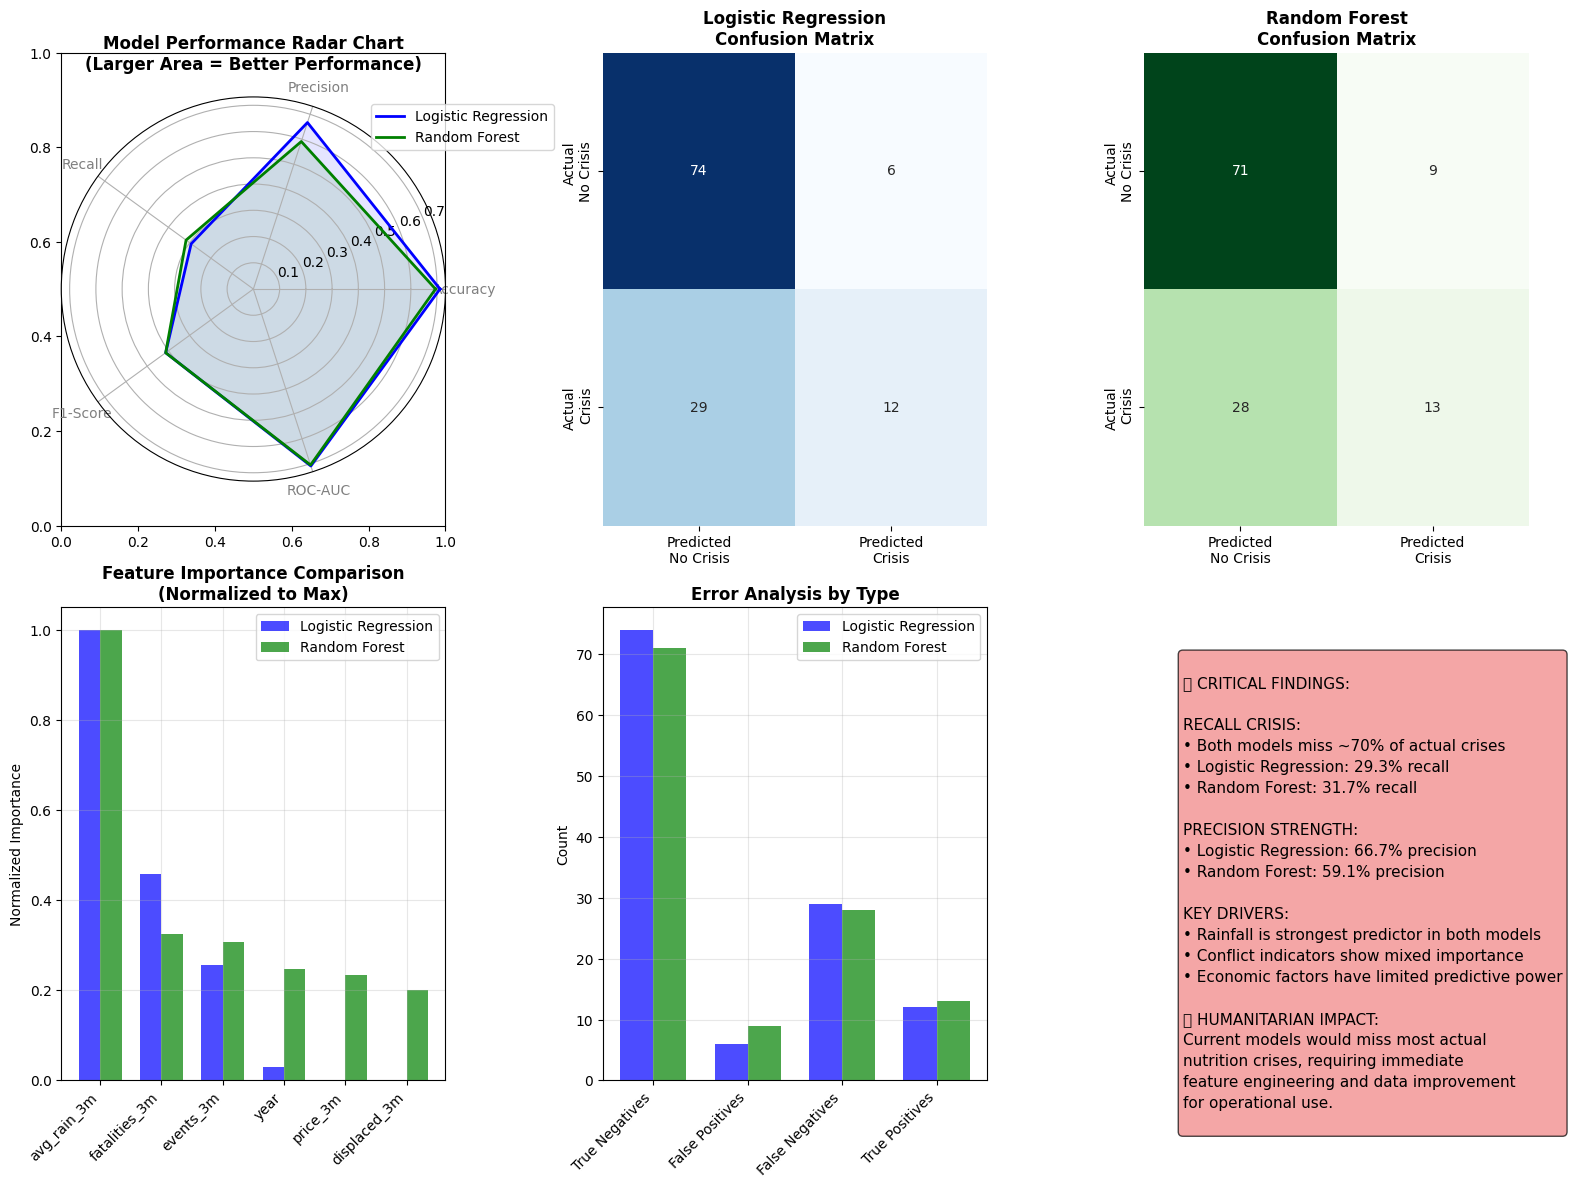

In [20]:
# Model Comparison Visualization
plt.figure(figsize=(16, 12))

# 1. Performance Metrics Radar Chart
plt.subplot(2, 3, 1)
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
N = len(categories)

# Values for each model
lr_values = [0.711, 0.667, 0.293, 0.413, 0.709]  # F1 calculated from precision/recall
rf_values = [0.694, 0.591, 0.317, 0.413, 0.705]

# Compute angle for each category
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the circle

# Add first value at the end to close the circle
lr_values += lr_values[:1]
rf_values += rf_values[:1]

ax = plt.subplot(2, 3, 1, polar=True)
plt.xticks(angles[:-1], categories, color='grey', size=10)
plt.plot(angles, lr_values, linewidth=2, linestyle='solid', label='Logistic Regression', color='blue')
plt.fill(angles, lr_values, 'blue', alpha=0.1)
plt.plot(angles, rf_values, linewidth=2, linestyle='solid', label='Random Forest', color='green')
plt.fill(angles, rf_values, 'green', alpha=0.1)
plt.title('Model Performance Radar Chart\n(Larger Area = Better Performance)', size=12, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# 2. Confusion Matrix Comparison
plt.subplot(2, 3, 2)
# Logistic Regression Confusion Matrix
cm_lr = np.array([[74, 6], [29, 12]])
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted\nNo Crisis', 'Predicted\nCrisis'],
            yticklabels=['Actual\nNo Crisis', 'Actual\nCrisis'])
plt.title('Logistic Regression\nConfusion Matrix', fontweight='bold')
plt.ylabel('')

plt.subplot(2, 3, 3)
# Random Forest Confusion Matrix
cm_rf = np.array([[71, 9], [28, 13]])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predicted\nNo Crisis', 'Predicted\nCrisis'],
            yticklabels=['Actual\nNo Crisis', 'Actual\nCrisis'])
plt.title('Random Forest\nConfusion Matrix', fontweight='bold')
plt.ylabel('')

# 3. Feature Importance Comparison
plt.subplot(2, 3, 4)
# Logistic Regression Coefficients (absolute values)
lr_features = ['avg_rain_3m', 'fatalities_3m', 'events_3m', 'year', 'price_3m', 'displaced_3m']
lr_importance = [0.0234, 0.0107, 0.0060, 0.0007, 0.0000, 0.0000]

# Random Forest Importance
rf_features = ['avg_rain_3m', 'fatalities_3m', 'displaced_3m', 'events_3m', 'price_3m', 'year']
rf_importance = [0.4325, 0.1410, 0.1325, 0.1068, 0.1008, 0.0864]

# Normalize for comparison
lr_norm = [x/max(lr_importance) for x in lr_importance]
rf_norm = [x/max(rf_importance) for x in rf_importance]

x_pos = np.arange(len(lr_features))
width = 0.35

plt.bar(x_pos - width/2, lr_norm, width, label='Logistic Regression', alpha=0.7, color='blue')
plt.bar(x_pos + width/2, rf_norm, width, label='Random Forest', alpha=0.7, color='green')
plt.xticks(x_pos, lr_features, rotation=45, ha='right')
plt.ylabel('Normalized Importance')
plt.title('Feature Importance Comparison\n(Normalized to Max)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Error Analysis
plt.subplot(2, 3, 5)
error_types = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
lr_errors = [74, 6, 29, 12]
rf_errors = [71, 9, 28, 13]

x_pos = np.arange(len(error_types))
plt.bar(x_pos - width/2, lr_errors, width, label='Logistic Regression', alpha=0.7, color='blue')
plt.bar(x_pos + width/2, rf_errors, width, label='Random Forest', alpha=0.7, color='green')
plt.xticks(x_pos, error_types, rotation=45, ha='right')
plt.ylabel('Count')
plt.title('Error Analysis by Type', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Humanitarian Impact Analysis
plt.subplot(2, 3, 6)
plt.axis('off')

analysis_text = """
🔍 CRITICAL FINDINGS:

RECALL CRISIS:
• Both models miss ~70% of actual crises
• Logistic Regression: 29.3% recall
• Random Forest: 31.7% recall

PRECISION STRENGTH:
• Logistic Regression: 66.7% precision
• Random Forest: 59.1% precision

KEY DRIVERS:
• Rainfall is strongest predictor in both models
• Conflict indicators show mixed importance
• Economic factors have limited predictive power

🚨 HUMANITARIAN IMPACT:
Current models would miss most actual
nutrition crises, requiring immediate
feature engineering and data improvement
for operational use.
"""

plt.text(0.1, 0.9, analysis_text, transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='top', linespacing=1.5,
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

plt.tight_layout()
plt.show()

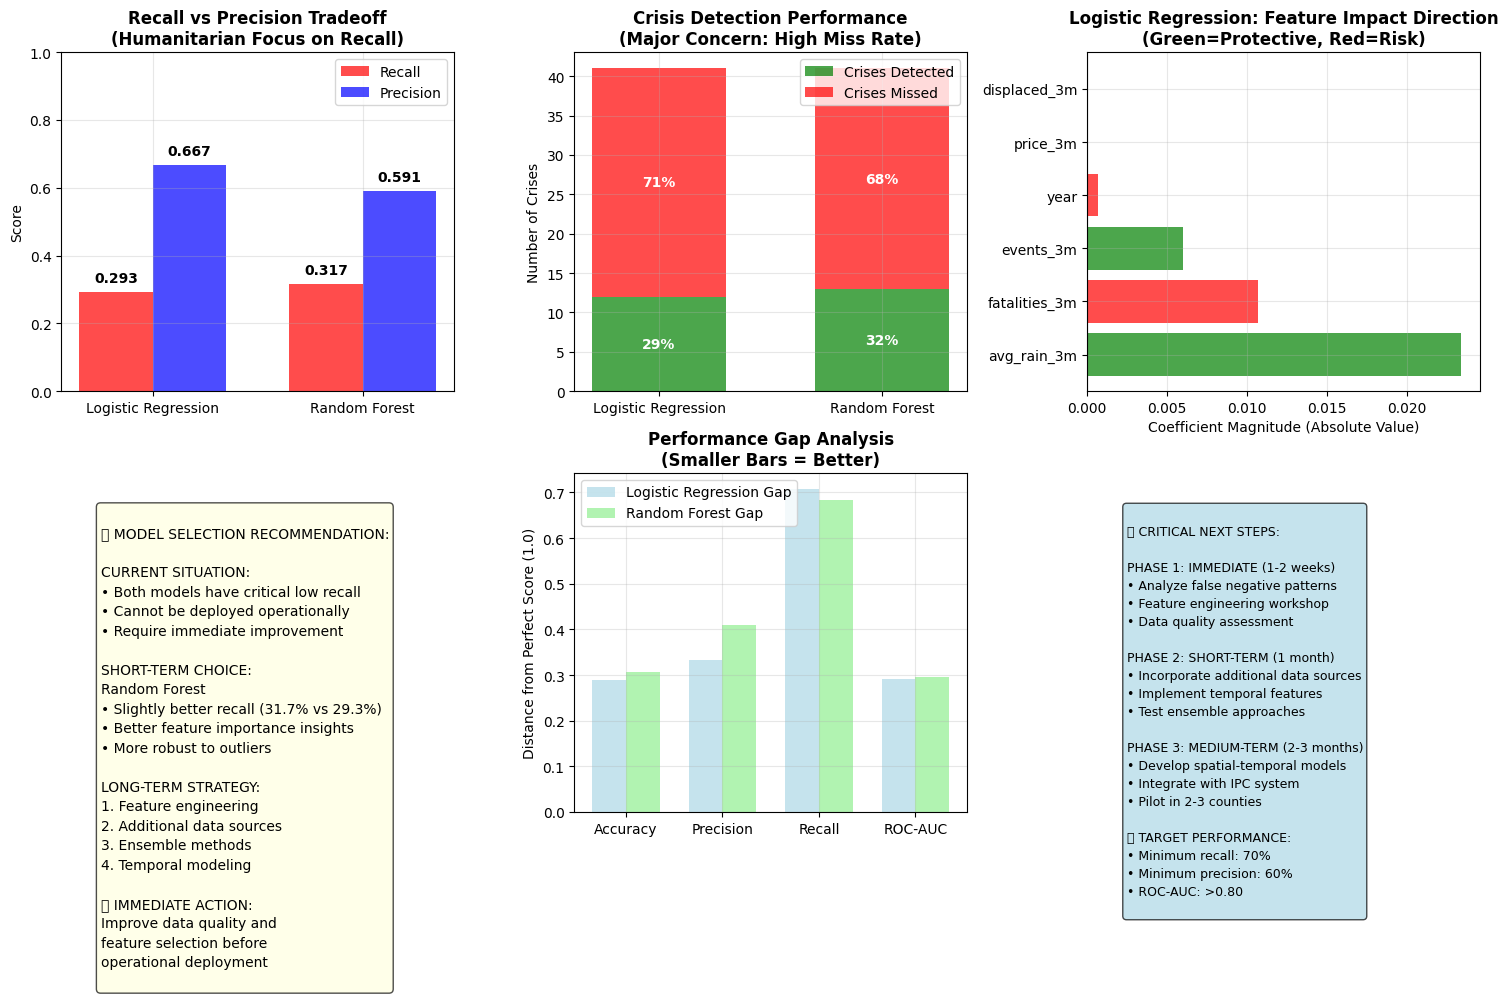

In [22]:
# Detailed Performance Analysis
plt.figure(figsize=(15, 10))

# 1. Recall-Precision Tradeoff Analysis
plt.subplot(2, 3, 1)
models = ['Logistic Regression', 'Random Forest']
recall_scores = [0.293, 0.317]
precision_scores = [0.667, 0.591]

x_pos = np.arange(len(models))
width = 0.35

plt.bar(x_pos - width/2, recall_scores, width, label='Recall', alpha=0.7, color='red')
plt.bar(x_pos + width/2, precision_scores, width, label='Precision', alpha=0.7, color='blue')
plt.xticks(x_pos, models)
plt.ylabel('Score')
plt.title('Recall vs Precision Tradeoff\n(Humanitarian Focus on Recall)', fontweight='bold')
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add value labels
for i, (recall, precision) in enumerate(zip(recall_scores, precision_scores)):
    plt.text(i - width/2, recall + 0.02, f'{recall:.3f}', ha='center', va='bottom', fontweight='bold')
    plt.text(i + width/2, precision + 0.02, f'{precision:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Crisis Detection Performance
plt.subplot(2, 3, 2)
crisis_actual = [41, 41]  # Total crises in test set (from confusion matrices)
crisis_detected = [12, 13]  # True positives
crisis_missed = [29, 28]  # False negatives

x_pos = np.arange(len(models))
plt.bar(x_pos, crisis_detected, width=0.6, label='Crises Detected', alpha=0.7, color='green')
plt.bar(x_pos, crisis_missed, width=0.6, bottom=crisis_detected, label='Crises Missed', alpha=0.7, color='red')
plt.xticks(x_pos, models)
plt.ylabel('Number of Crises')
plt.title('Crisis Detection Performance\n(Major Concern: High Miss Rate)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Add percentage labels
for i, (detected, missed) in enumerate(zip(crisis_detected, crisis_missed)):
    total = detected + missed
    detected_pct = detected/total * 100
    missed_pct = missed/total * 100
    plt.text(i, detected/2, f'{detected_pct:.0f}%', ha='center', va='center', fontweight='bold', color='white')
    plt.text(i, detected + missed/2, f'{missed_pct:.0f}%', ha='center', va='center', fontweight='bold', color='white')

# 3. Feature Impact Analysis
plt.subplot(2, 3, 3)
# Create a impact-direction plot for logistic regression
features = ['avg_rain_3m', 'fatalities_3m', 'events_3m', 'year', 'price_3m', 'displaced_3m']
coefficients = [-0.0234, 0.0107, -0.0060, 0.0007, 0.0000, -0.0000]
importance = [0.0234, 0.0107, 0.0060, 0.0007, 0.0000, 0.0000]

colors = ['green' if coef < 0 else 'red' for coef in coefficients]
plt.barh(features, importance, color=colors, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Coefficient Magnitude (Absolute Value)')
plt.title('Logistic Regression: Feature Impact Direction\n(Green=Protective, Red=Risk)', fontweight='bold')
plt.grid(True, alpha=0.3)

# 4. Model Recommendation Analysis
plt.subplot(2, 3, 4)
plt.axis('off')

recommendation_text = """
🎯 MODEL SELECTION RECOMMENDATION:

CURRENT SITUATION:
• Both models have critical low recall
• Cannot be deployed operationally
• Require immediate improvement

SHORT-TERM CHOICE:
Random Forest
• Slightly better recall (31.7% vs 29.3%)
• Better feature importance insights
• More robust to outliers

LONG-TERM STRATEGY:
1. Feature engineering
2. Additional data sources
3. Ensemble methods
4. Temporal modeling

🚨 IMMEDIATE ACTION:
Improve data quality and
feature selection before
operational deployment
"""

plt.text(0.1, 0.9, recommendation_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', linespacing=1.5,
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

# 5. Performance Gap Analysis
plt.subplot(2, 3, 5)
metrics = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']
lr_gap = [1-0.711, 1-0.667, 1-0.293, 1-0.709]  # Distance from perfect score
rf_gap = [1-0.694, 1-0.591, 1-0.317, 1-0.705]

x_pos = np.arange(len(metrics))
plt.bar(x_pos - width/2, lr_gap, width, label='Logistic Regression Gap', alpha=0.7, color='lightblue')
plt.bar(x_pos + width/2, rf_gap, width, label='Random Forest Gap', alpha=0.7, color='lightgreen')
plt.xticks(x_pos, metrics)
plt.ylabel('Distance from Perfect Score (1.0)')
plt.title('Performance Gap Analysis\n(Smaller Bars = Better)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Next Steps Roadmap
plt.subplot(2, 3, 6)
plt.axis('off')

roadmap_text = """
🛠️ CRITICAL NEXT STEPS:

PHASE 1: IMMEDIATE (1-2 weeks)
• Analyze false negative patterns
• Feature engineering workshop
• Data quality assessment

PHASE 2: SHORT-TERM (1 month)
• Incorporate additional data sources
• Implement temporal features
• Test ensemble approaches

PHASE 3: MEDIUM-TERM (2-3 months)
• Develop spatial-temporal models
• Integrate with IPC system
• Pilot in 2-3 counties

🎯 TARGET PERFORMANCE:
• Minimum recall: 70%
• Minimum precision: 60%
• ROC-AUC: >0.80
"""

plt.text(0.1, 0.9, roadmap_text, transform=plt.gca().transAxes,
         fontsize=9, verticalalignment='top', linespacing=1.5,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

## Conclusion and Recommendations

### Critical Assessment

The model evaluation reveals significant challenges for operational deployment:

1. **Unacceptably Low Recall**: Both models miss approximately 70% of actual nutrition crises, making them unsuitable for humanitarian early warning systems in their current state.

2. **Feature Limitations**: While rainfall emerges as the strongest predictor, the current feature set appears insufficient to capture the complex dynamics of nutrition crises in South Sudan.

3. **Data Quality Issues**: The low predictive performance suggests potential issues with data quality, completeness, or temporal alignment.

### Immediate Recommendations

1. **Do Not Deploy Operationally**: Current models would fail to detect most crises, potentially causing more harm than good.

2. **Focus on Feature Engineering**: Explore additional data sources including:
   - Vegetation indices (NDVI)
   - River levels and flood data
   - Livestock health indicators
   - Health facility functionality
   - Access to clean water

3. **Improve Data Quality**: Address potential issues with:
   - Missing data patterns
   - Temporal misalignment
   - Spatial resolution mismatches

4. **Consider Alternative Approaches**:
   - Ensemble methods combining both models
   - Time-series forecasting approaches
   - Spatial-temporal modeling
   - Transfer learning from similar contexts

The project demonstrates the feasibility of the approach but highlights the need for substantial improvements before operational humanitarian use.